# makemore: part 3

In [22]:
import torch
import torch.nn.functional as F
import os
import random
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Reading Names Dataset
print(f"Working dir: {os.getcwd()}")
dataset_path = os.path.join(os.getcwd(), "../makemore/names.txt")
words = open(dataset_path, 'r').read().splitlines()

print(f"\nDataset cherry picking: {words[:8]}")
print(f"Dataset size: {len(words)}")

Working dir: /Users/tomery/Library/CloudStorage/OneDrive-Mobileye/Documents/training_repos/zero_to_hero/exercises

Dataset cherry picking: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Dataset size: 32033


# ------------ Buliding Data Mapping and Dataset ---------------

In [23]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f"Mapping index to string: {itos}")
vocabulary_size = len(itos)
print(f"Mapping size: {vocabulary_size}")


Mapping index to string: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Mapping size: 27


In [24]:
# build the datasetc
def build_dataset(dataset = list, block_size = int):
  # block_size: context length, how many characters do we take to predict the next one?
  # returns: X as input features in size of contect length, Y as the labels.
  
  X, Y = [], []
  for w in dataset:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f"Features: {X.shape}, {X.dtype}\nLabels: {Y.shape}, {Y.dtype}")
  return X, Y
  

# Split the dataset to train ; dev/validation ; test
random.seed(42) # Set seed for reproducibility
random.shuffle(words)

block_size = 3 
dev_dataset_index = int(0.8*len(words))
test_dataset_index = int(0.9*len(words))

print("Train:")
Xtr, Ytr = build_dataset(words[:dev_dataset_index], block_size=block_size)
print("Dev:")
Xdev, Ydev = build_dataset(words[dev_dataset_index:test_dataset_index], block_size=block_size)
print("Test:")
Xte, Yte = build_dataset(words[test_dataset_index:], block_size=block_size)

Train:
Features: torch.Size([182625, 3]), torch.int64
Labels: torch.Size([182625]), torch.int64
Dev:
Features: torch.Size([22655, 3]), torch.int64
Labels: torch.Size([22655]), torch.int64
Test:
Features: torch.Size([22866, 3]), torch.int64
Labels: torch.Size([22866]), torch.int64


# ------------ Buliding MLP Architecture ---------------

In [25]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.weight = torch.zeros((fan_in, fan_out)) 
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


### -------------- Build the Model --------------

In [26]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocabulary_size, n_embd), generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocabulary_size, bias=False), BatchNorm1d(vocabulary_size),
# ]

layers = [
  Linear(n_embd * block_size, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocabulary_size, bias=False), BatchNorm1d(vocabulary_size),
]


with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47524


In [34]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.8135
  10000/ 200000: 2.8222
  20000/ 200000: 2.8831
  30000/ 200000: 2.7341
  40000/ 200000: 3.1098
  50000/ 200000: 2.9041
  60000/ 200000: 2.7780
  70000/ 200000: 2.7191
  80000/ 200000: 2.8808
  90000/ 200000: 2.7309
 100000/ 200000: 2.5945
 110000/ 200000: 2.8811
 120000/ 200000: 2.6836
 130000/ 200000: 2.7799
 140000/ 200000: 2.7450
 150000/ 200000: 2.8247
 160000/ 200000: 2.5782
 170000/ 200000: 2.7081
 180000/ 200000: 2.8040
 190000/ 200000: 3.3653


layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

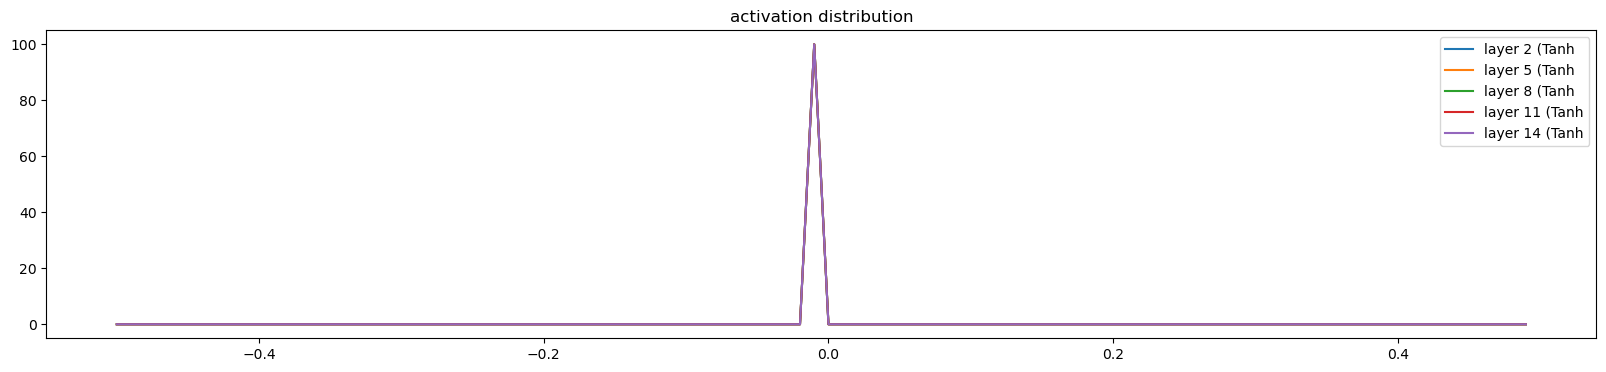

In [35]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

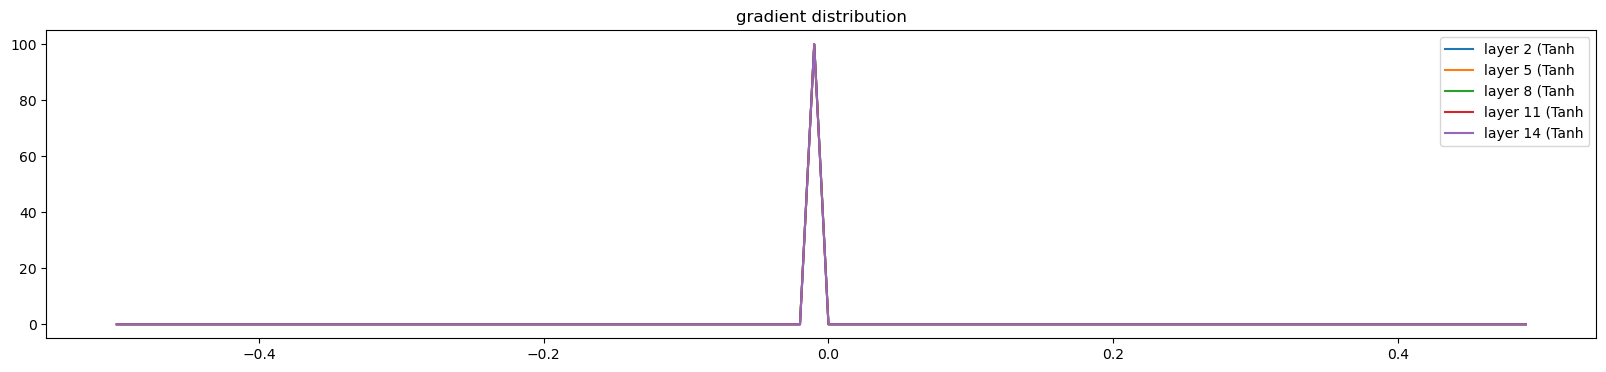

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


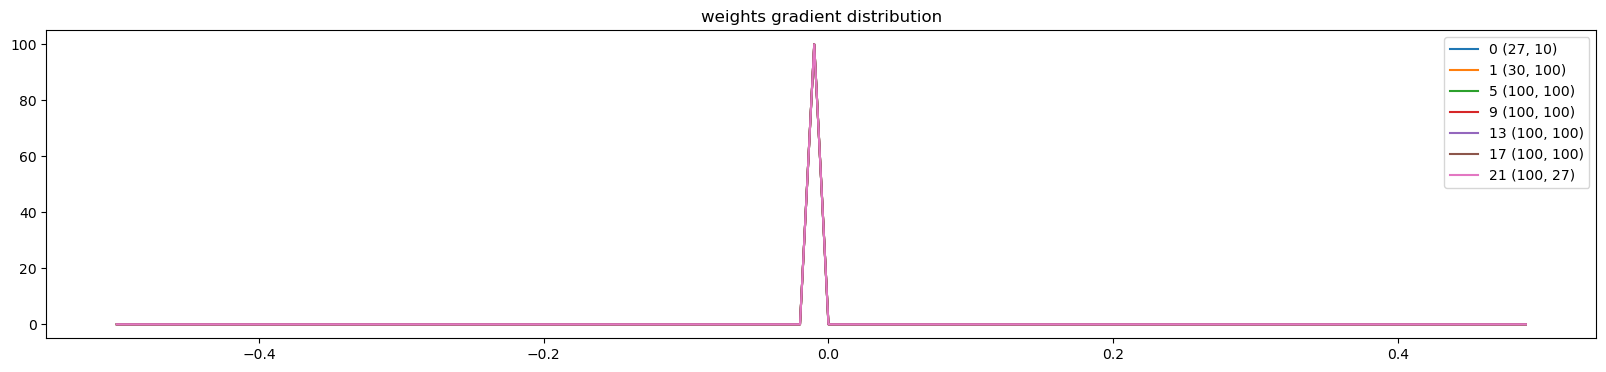

In [30]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

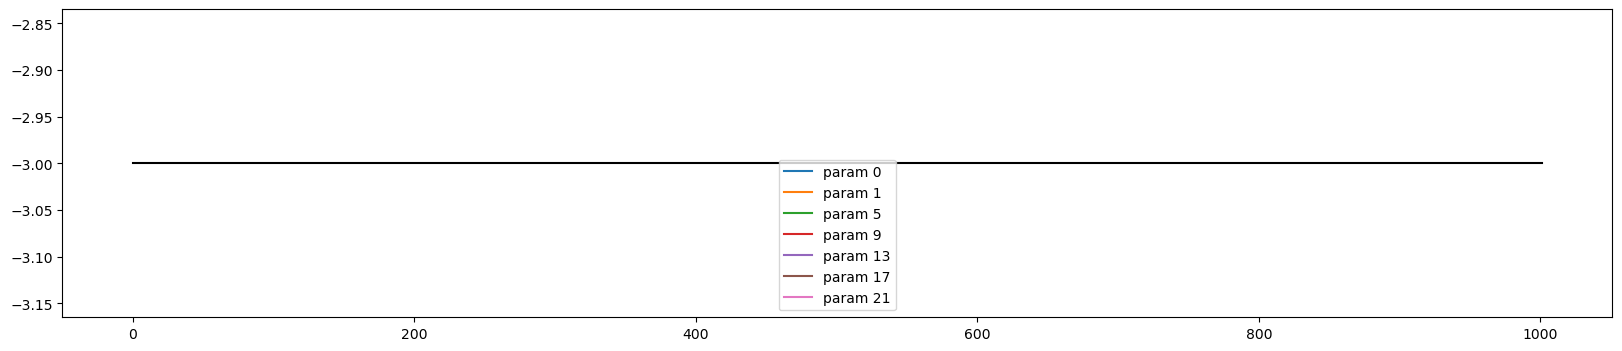

In [31]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [37]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  print(x, y)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02,  ...,  6.0489e-01,
          7.9136e-02,  9.0462e-01],
        [ 1.5674e+00, -2.3729e-01, -2.7385e-02,  ..., -8.1628e-01,
         -3.9243e-01, -7.4521e-01],
        [ 1.5674e+00, -2.3729e-01, -2.7385e-02,  ..., -1.9295e-01,
          1.2348e+00,  3.3308e-01],
        ...,
        [ 5.5570e-01,  4.7458e-01, -1.3867e+00,  ...,  4.5846e-01,
          5.4011e-02, -1.7400e+00],
        [-5.6144e-01, -1.3753e-01, -1.3799e-01,  ..., -1.6261e+00,
          6.7716e-01, -8.4040e-01],
        [-9.6478e-01, -2.3211e-01, -3.4762e-01,  ..., -4.5585e-01,
         -1.3132e-03, -5.1161e-01]]) tensor([25, 21,  8,  ...,  1, 14,  0])
train 2.8226535320281982
tensor([[ 1.5674, -0.2373, -0.0274,  ...,  0.6049,  0.0791,  0.9046],
        [ 1.5674, -0.2373, -0.0274,  ..., -1.6261,  0.6772, -0.8404],
        [ 1.5674, -0.2373, -0.0274,  ...,  0.3175,  1.0588,  2.3982],
        ...,
        [-1.1641,  1.2473, -0.2706,  ..., -0.8163, -0.3924, -0.7452],
        [-0

In [38]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

narmahxaae.
hlrihkimrs.
reaty.
hnaassnejr.
hnenfamesahc.
iaeei.
.
ermaia.
ceaiivde.
lein.
h.
.
m.
.
oin.
eeijn.
s.
lilea.
.
adbi.


### Weights are initialized to be randoms. Bias initialized to be zeros:
- Loss: 0/ 200000: 3.2870

- layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
- layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
- layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
- layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
- layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%

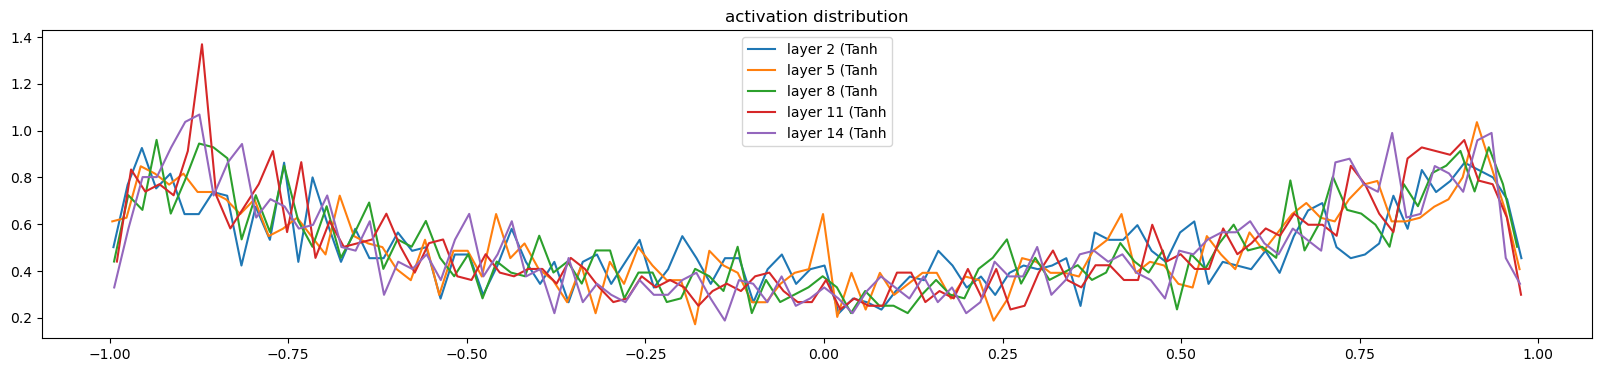
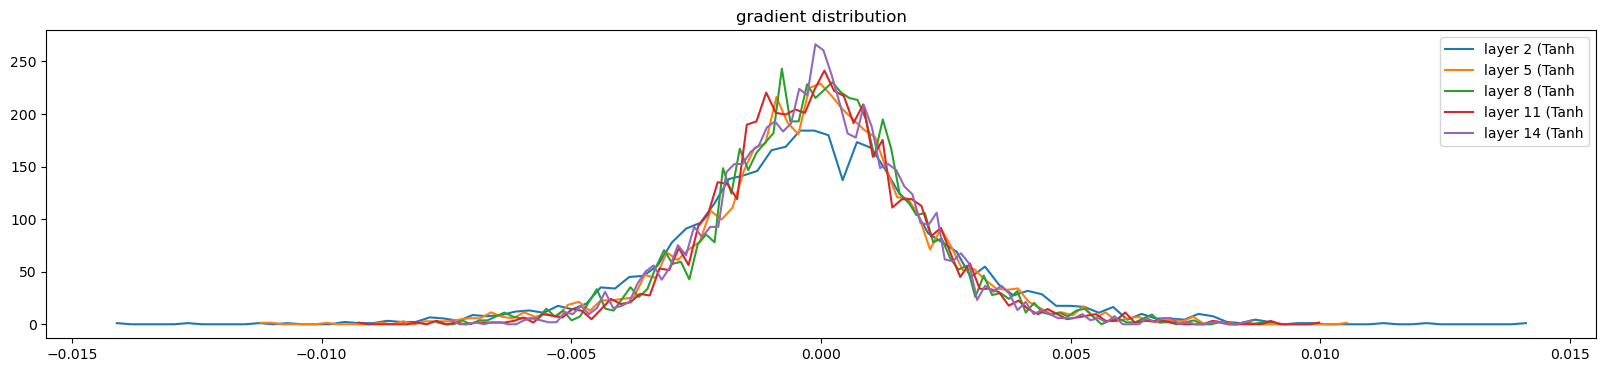
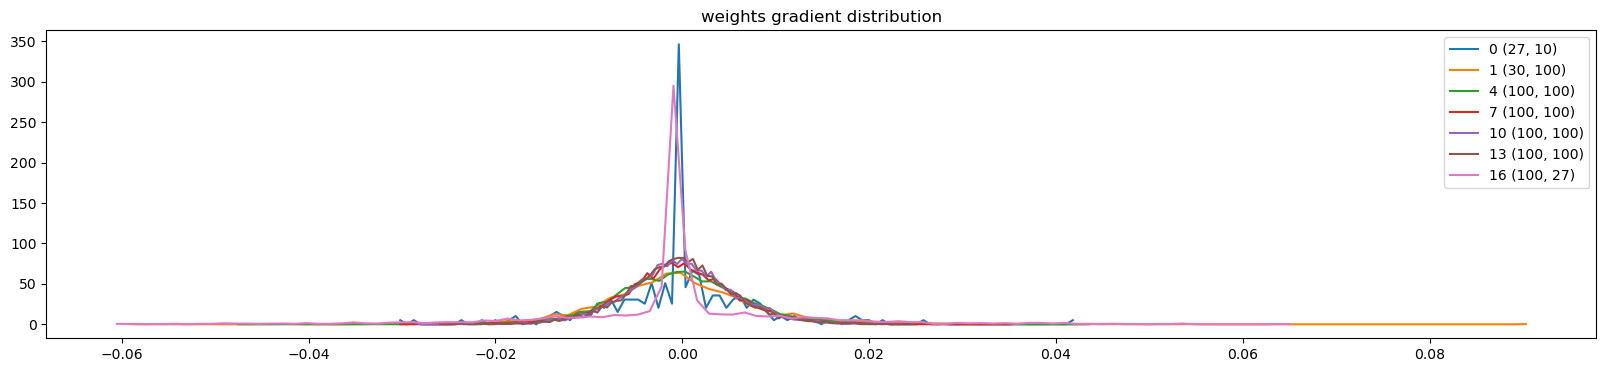
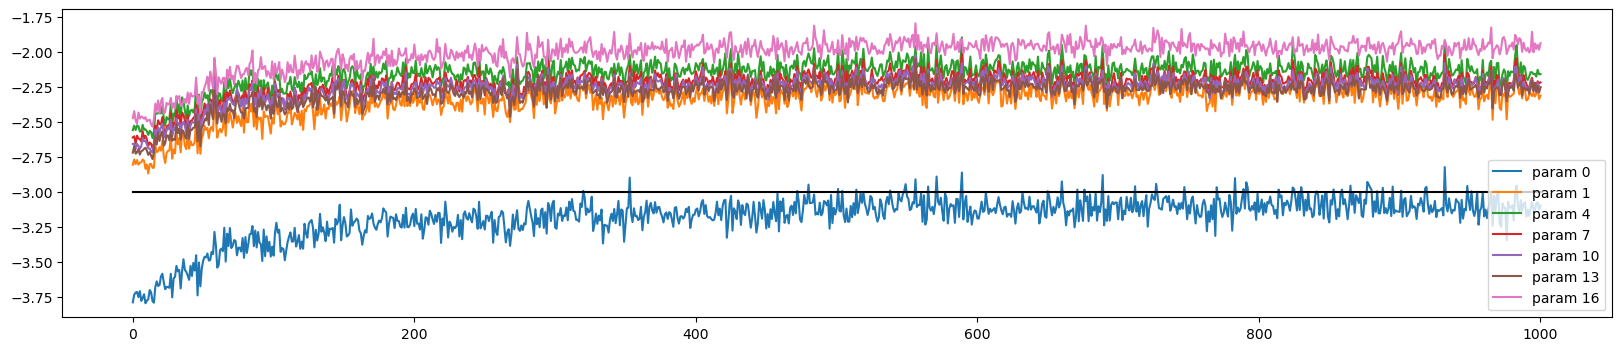

### Weights and biases are initialized to be zeros:
- Loss: 0/ 200000: 3.2958

- layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
- layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
- layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
- layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
- layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%

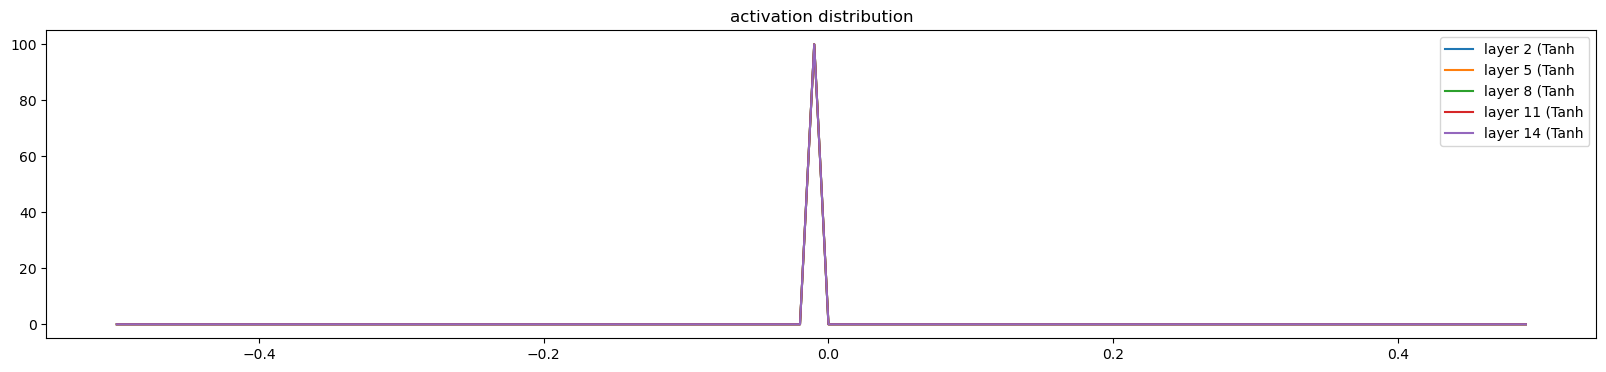
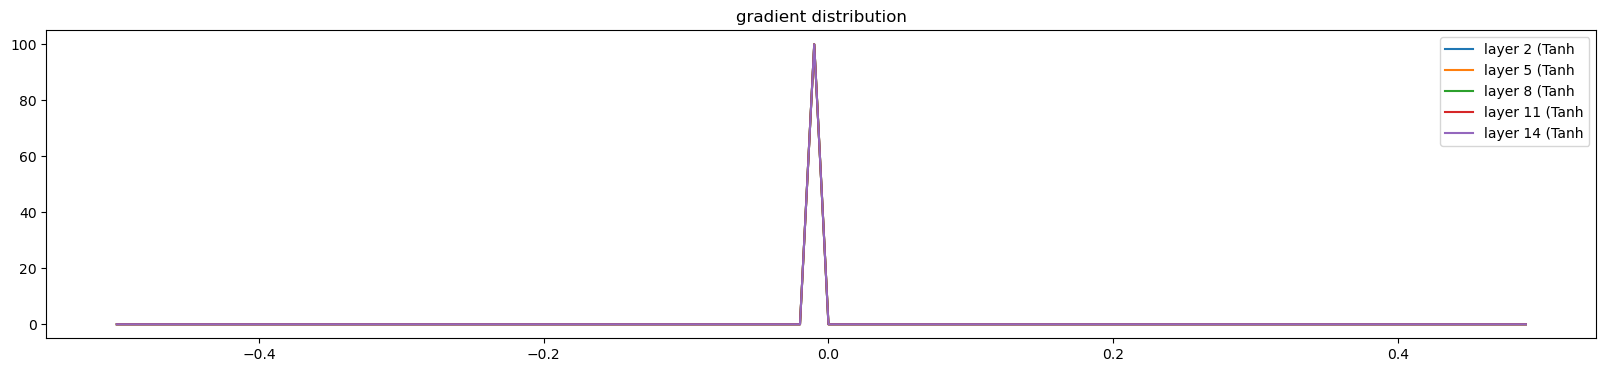
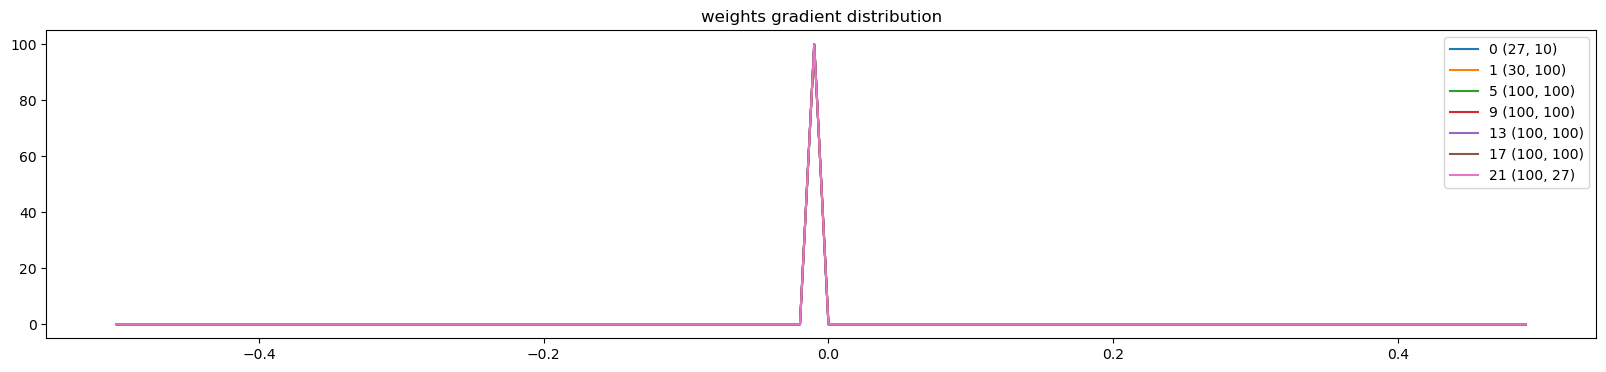
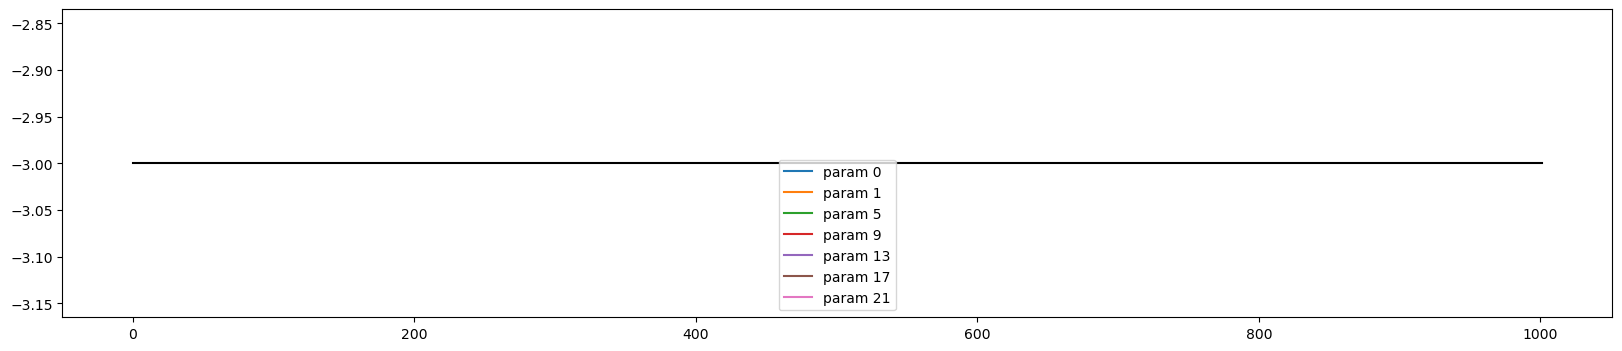

- With zeros weights and biases, the network trains but only partially, and achieves a pretty bad final performance.
    - It happens because there is no variance in the activation or bias stage. All weights are starting in the same place and hardly moving.


# E02: Folding Batchnorm Parameters to Linear Layer
- Set up and train a small 3-layer MLP with batchnorms, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b
by creating a new W2, b2 and erasing the batch norm. 
- Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

## Explaination (From Bing Chat with modifcations)
BatchNorm is a technique that normalizes the input of each layer to make the training process faster and more stable.
It consists of two steps:

    1- normalizing the batch by subtracting its mean and dividing it by its standard deviation.
    2- scaling and shifting it by two learnable parameters called gamma and beta.

However, at inference time, BatchNorm is **not necessary** and can be removed to speed up the network.

One way to remove BatchNorm is to fold it into the preceding linear layer, which is also a `linear transformation`.

This means that we can combine the `weights` and `biases` of the **linear** **layer** with the `gamma` and `beta` of the **BatchNorm layer** to get a new linear layer that has the same output as the original one.

This can be done by rearranging the terms of the linear transformation as follows:

$$
y = \text{Linear}(x) = Wx + b
$$

$$
z = \text{BatchNorm}(y) = \gamma \frac{y - \mu}{\sigma} + \beta
$$

$$
z = \text{BatchNorm}(\text{Linear}(x)) = \gamma \frac{Wx + b - \mu}{\sigma} + \beta
$$

$$
z = (\frac{\gamma}{\sigma})Wx + (\frac{\gamma}{\sigma})(b - \mu) + \beta
$$

$$
z = W_2 x + b_2
$$

where $$W_2 = (\frac{\gamma}{\sigma})W$$ and $$b_2 = (\frac{\gamma}{\sigma})(b - \mu) + \beta$$


## Init The Model

In [40]:
# visualization parameters (play with these)
gain = 3/5
last_layer_confidence = 0.1

using_batch_norm = True
div_by_fan_in = True

In [42]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)
        if div_by_fan_in:
            self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocabulary_size, n_embd),       generator = g)

if not using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, vocabulary_size)
    ]
if using_batch_norm:
    layers = [
    Linear(n_embd * block_size, n_hidden, bias = True), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = True), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, vocabulary_size, bias = True), BatchNorm1d(vocabulary_size) # you can add it here too
    ]

with torch.no_grad():
    # last layer: make less confident
    if not using_batch_norm:
        layers[-1].weight *= last_layer_confidence
    if using_batch_norm:
        layers[-1].gamma *= last_layer_confidence
    
    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # change this gain (default 5/3)
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

16651


## Training

In [44]:
# same optimization as last time
# set it training mode
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    x = emb.view((emb.shape[0], -1)) # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")
    
    # DEBUG Only:
    # if i == 10000:
    #     break

    lossi.append(loss.item())

    # update to data ratio: How great is the update compared to the data itself?
    with torch.no_grad():
        update_to_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters if p.grad is not None])

step 0 loss 2.221792697906494
step 10000 loss 2.36242938041687
step 20000 loss 2.132382869720459
step 30000 loss 1.8863486051559448
step 40000 loss 1.8679516315460205
step 50000 loss 2.3004674911499023
step 60000 loss 2.0893924236297607
step 70000 loss 1.945767879486084
step 80000 loss 2.604797601699829
step 90000 loss 1.990554928779602
step 100000 loss 1.9775604009628296
step 110000 loss 2.1686902046203613
step 120000 loss 2.3155014514923096
step 130000 loss 2.3300621509552
step 140000 loss 2.199270248413086
step 150000 loss 2.1311473846435547
step 160000 loss 2.025944471359253
step 170000 loss 2.097358465194702
step 180000 loss 2.3074278831481934
step 190000 loss 2.1717193126678467


## Testing (With BatchNorm):

In [47]:
# forward pass
emb = C[Xte] # embed characters into vector space
x = emb.view((emb.shape[0], -1)) # flatten
for layer in layers:
    layer.training = False
    x = layer(x)

# compute loss
loss = F.cross_entropy(x, Yte)
print(f"test loss {loss.item()}")

test loss 2.117671012878418


## Testing (Folded BatchNorm to Previous Linear Layer):

In [48]:
emb = C[Xte] # embed zharacters into vector space
x = emb.view((emb.shape[0], -1)) # flatten

for layeridx in range(len(layers)):
    # forward pass through Linear layers only (Neglect batch norm)
    if isinstance(layers[layeridx], Linear):
        # fold the batch norm into the weights
        l = Linear(layers[layeridx].weight.shape[0], layers[layeridx].weight.shape[1], bias = True)
        
        l.weight = layers[layeridx].weight * (layers[layeridx + 1].gamma / torch.sqrt(layers[layeridx + 1].running_var + layers[layeridx + 1].eps))
        if layers[layeridx].bias is not None:
            l.bias = (layers[layeridx].bias - layers[layeridx + 1].running_mean) * (layers[layeridx + 1].gamma / torch.sqrt(layers[layeridx + 1].running_var + layers[layeridx + 1].eps)) + layers[layeridx + 1].beta
            
        x = l(x)
    if isinstance(layers[layeridx], Tanh):
        x = layers[layeridx](x)

# compute loss
loss = F.cross_entropy(x, Yte)
print(f"test loss {loss.item()}")

test loss 2.117671012878418


In [39]:
# DONE; BONUS content below, not covered in video

In [14]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [15]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [16]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
